In [10]:
import tensorflow as tf
import keras
import cv2
import nltk

Using TensorFlow backend.


In [11]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input,Dense,Dropout,Embedding,LSTM
from keras.layers import add

# READ TEXT CAPTIONS

In [12]:
import matplotlib.pyplot as plt

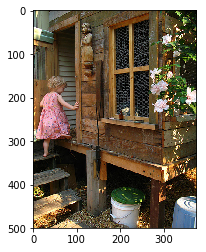

In [13]:
img=cv2.imread('C:/Users/Neha Yadav/Desktop/Flickr_Data/Images/1000268201_693b08cb0e.jpg')
newimg=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(newimg)
plt.show()

In [14]:
def readTextFile(path):
    with open(path) as f:
        captions=f.read()
    return captions

In [15]:
captions=readTextFile("C:/Users/Neha Yadav/Desktop/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")
print(len(captions.split("\n")))
captions=captions.split('\n')[:-1]
len(captions)

40461


40460

# DICTIONARY TO MAP EACH IMAGE WITH THE LIST OF CAPTIONS IT HAS

In [16]:
descriptions={}

for x in captions:
    first,second=x.split('\t')
    img_name=first.split('.')[0]
    
    #if image is already present or not
    if descriptions.get(img_name) is None:
        descriptions[img_name]=[]
    
    descriptions[img_name].append(second)

In [17]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

# TEXT CLEANING

In [18]:
def clean_txt(sentence):
    sentence=sentence.lower()
    sentence=re.sub("[^a-z]+"," ",sentence)
    sentence=sentence.split(" ")
    
    
    sentence=[s for s in sentence if len(s)>1]
    sentence=" ".join(sentence)
    return sentence

In [19]:
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i]=clean_txt(caption_list[i])

In [20]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [21]:
#Store the data to text file
with open("descriptions_1.txt","w") as f:
    f.write(str(descriptions))

# VOCABLARY

In [22]:
descriptions=None
with open("descriptions_1.txt",'r') as f:
    descriptions=f.read()

json_acceptable_string=descriptions.replace("'","\"")
descriptions=json.loads(json_acceptable_string)

In [23]:
print(type(descriptions))

<class 'dict'>


In [24]:
vocab=set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]

In [25]:
print(len(vocab))

8424


In [26]:
#TOTAL WORDS ACROSS ALL SENTENCES
total_words=[]

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
print(len(total_words))

373837


In [27]:
#FILTER WORDS FROM THE VOCAB ACCORDING TO SOME THRESHOLD FREQUENCY
import collections

counter=collections.Counter(total_words)
freq_count=dict(counter)
print(len(freq_count.keys()))

8424


In [28]:
#SORT THIS DICTIONARY ACCORDING TO FREQUENCY COUNT
sorted_freq_count=sorted(freq_count.items(),reverse=True,key=lambda x:x[1])

threshold=10;
sorted_freq_count=[x for x in sorted_freq_count if x[1]>threshold]
total_words=[x[0] for x in sorted_freq_count]
print(len(total_words))

1845


# PREPARE TRAIN/TEST DATA

In [66]:
train_file_data=readTextFile("C:/Users/Neha Yadav/Desktop/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data=readTextFile("C:/Users/Neha Yadav/Desktop/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")

train=[row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
#print(train)
test=[row.split(".")[0] for row in test_file_data.split("\n")[:-1]]
#print(test)

In [30]:
train_descriptions={}

for img in train:
    train_descriptions[img]=[]
    for cap in descriptions[img]:
        cap_to_append="startseq "+cap+" endseq"
        train_descriptions[img].append(cap_to_append)

In [31]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

# TRANSFER LEARNING


IMAGES-->FEATURES                                                                                                 
TEXT-->FEATURES

In [32]:
model=ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________

In [33]:
model_new=Model(model.input,model.layers[-2].output)

In [34]:
def preprocess_img(img):
    img=image.load_img(img,target_size=(224,224))
    img=image.img_to_array(img)
    img=np.expand_dims(img,axis=0)
    
    #Normalisation
    img=preprocess_input(img)
    return img

In [35]:
#img=preprocess_img('C:/Users/Neha Yadav/Desktop/Flickr_Data/Images/1000268201_693b08cb0e.jpg')
#plt.imshow(img[0])
#plt.show()

In [36]:
def encode_image(img):
    img=preprocess_img(img)
    feature_vector=model_new.predict(img)
    feature_vector=feature_vector.reshape((-1,))
    return feature_vector

In [37]:
encoding_train={}
#WE WILL STORING IMAGE ID-->FEATURE VECTOR EXTRACTED FROM RESNET IMAGE

for ix,img_id in enumerate(train):
    img_path='C:/Users/Neha Yadav/Desktop/Flickr_Data/Images'+'/'+img_id+'.jpg'
    encoding_train[img_id]=encode_image(img_path)

In [39]:
with open("encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [49]:
encoding_test={}
#WE WILL STORING IMAGE ID-->FEATURE VECTOR EXTRACTED FROM RESNET IMAGE

for ix,img_id in enumerate(test):
    img_path='C:/Users/Neha Yadav/Desktop/Flickr_Data/Images'+'/'+img_id+'.jpg'
    encoding_test[img_id]=encode_image(img_path)

In [50]:
with open("encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

#Data pre-processsing for captions

In [51]:
#Vocab
len(total_words)

1845

In [56]:
word_to_idx={}
idx_to_word={}

for i,word in enumerate(total_words):
    word_to_idx[word]=i+1;
    idx_to_word[i+1]=word
    

In [58]:
#TWO SPECIAL WORDS
print(len(idx_to_word))

1845


In [83]:
idx_to_word[1846]='startseq'
word_to_idx['startseq']=1846

idx_to_word[1847]='endseq'
word_to_idx['endseq']=1847

vocab_size=len(word_to_idx)+1

In [64]:
max_len=0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len=max(max_len,len(cap.split()))
        
print(max_len)

35


# DATA LOADER(GENERATOR)

In [68]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    x1,x2,y =[],[],[]
    
    n=0
    while True:
        for key,desc_list in train.descriptions.items():
            n+=1
            
            photo=encoding_train[key+".jpg"]
            
            seq=[word_to_idx[word] for word in desc.split() if word in word_to_idx]
            for i in range(1,len(seq)):
                xi=seq[0:i]
                
                #0 denote padding word
                xi=pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                yi=to_categorcial([yi],num_classes=vocab_size)[0]
                
                x1.append(photo)
                x2.append(xi)
                y.append(yi)
                
                
            if n==batch_size:
                yield[[np.array(x1),np.array(x2)],np.array(y)]
                x1,x2,y=[],[],[]
                n=0

# WORD EMBEDDINGS

In [75]:
f=open('C:/Users/Neha Yadav/glove.6B.50d.txt',encoding='utf8')

In [77]:
embedding_index={}

for line in f:
    values=line.split()
    word=values[0]
    word_embedding=np.array(values[1:],dtype='float')
    embedding_index[word]=word_embedding

In [78]:
f.close()

In [84]:
def get_embedding_matrix():
    emb_dim=50
    matrix=np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector=embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx]=embedding_vector
            
    return matrix

In [85]:
embedding_matrix=get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

# MODEL ARCHITECHTURE

In [86]:
input_img_features=Input(shape=(2048,))
inp_img1=Dropout(0.3)(input_img_features)
inp_img2=Dense(256,activation='relu')(inp_img1)


In [87]:
#Captions as Input
input_captions=Input(shape=(max_len,))
inp_cap1=Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2=Dropout(0.3)(inp_cap1)
inp_cap3=LSTM(256)(inp_cap2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [88]:
decoder1=add([inp_img2,inp_cap3])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)

#Combined Model
model=Model(inputs=[input_img_features,input_captions],outputs=outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [90]:
#IMPORTANT LAYER-PRE INITIALIZE THE EMBEDDED LAYER
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable=False

In [91]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

# TRAIN OF MODEL

In [94]:
epochs=20
batch_size=3
steps=len(train_descriptions)//batch_size

In [ ]:
def train():
    
    for i in range(epochs):
        generator=data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('./model_weights/model_'+str(i)+'.h5')

In [ ]:
model=load_model('./model_weights/model_9.h5')

# PRECAUTIONS 